# CSE527 Homework 3
**Due date: 23:59 on Oct 22, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Using SIFT in OpenCV 3.x.x in Colab
---
The default version of OpenCV in Colab is 3.4.3. If we use SIFT method directly, typically we will get this error message:

```
error: OpenCV(3.4.3) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

```

One simple way to use the OpenCV in-built function `SIFT` in Colab is to switch the version to the one from 'contrib'. Below is an example of switching OpenCV version:

1. Run the following command in one section in Colab, which has already been included in this assignment:
```
pip install opencv-contrib-python==3.4.2.16
```
2. Restart runtime by
```
Runtime -> Restart Runtime
```

Then you should be able to use use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html


## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 16 categories by training and testing on the 16
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---

The starter code trains on 150 and tests on 50 images from each category (i.e. 2400
training examples total and 800 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.

Save the [dataset(click me)](https://drive.google.com/drive/folders/1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M?usp=sharing) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.25% accuracy
(1 out of 16 guesses is correct).

In [0]:
pip install opencv-contrib-python==3.4.2.16

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle
import os
from sklearn import svm
from skimage import color
from skimage import io
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix

print(cv2.__version__) # verify OpenCV version

3.4.2


In [0]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Data Preparation

In [0]:
# class_names = [name[13:] for name in glob.glob('./data/train/*')]
# class_names = dict(zip(range(len(class_names)), class_names))
# print("class_names: %s " % class_names)
# n_train_samples_per_class = 150
# n_test_samples_per_class = 50

# def load_dataset(path, num_per_class=-1):
#     data = []
#     labels = []
#     for id, class_name in class_names.items():
#         print("Loading images from class: %s" % id)
#         img_path_class = glob.glob(path + class_name + '/*.jpg')
#         if num_per_class > 0:
#             img_path_class = img_path_class[:num_per_class]
#         labels.extend([id]*len(img_path_class))
#         for filename in img_path_class:
#             data.append(cv2.imread(filename, 0))
#     return data, labels


# load training dataset
# train_data, train_label = load_dataset('./data/train/')
# train_data, train_label = load_dataset('./data/train/', n_train_samples_per_class)
# n_train = len(train_label)
# print("n_train: %s" % n_train)

# load testing dataset
# test_data, test_label = load_dataset('./data/test/')
# test_data, test_label = load_dataset('./data/test/', n_test_samples_per_class)
# n_test = len(test_label)
# print("n_test: %s" % n_test)


In [0]:
# # As loading the data from the source for the first time is time consuming, so you can pkl or save the data in a compact way such that subsequent data loading is faster
# # Save intermediate image data into disk
# file = open('train.pkl','wb')
# pickle.dump(train_data, file)
# pickle.dump(train_label, file)
# file.close()

# file = open('test.pkl','wb')
# pickle.dump(test_data, file)
# pickle.dump(test_label, file)
# file.close()

In [0]:
# Load intermediate image data from disk
file = open('train.pkl', 'rb')
train_data = pickle.load(file)
train_label = pickle.load(file)
file.close()

file = open('test.pkl', 'rb')
test_data = pickle.load(file)
test_label = pickle.load(file)
file.close()

print(len(train_data), len(train_label)) # Verify number of training samples
print(len(test_data), len(test_label))   # Verify number of testing samples

2400 2400
400 400


In [0]:
# plt.imshow(train_data[1], cmap='gray') # Verify image
img_new_size = (240, 240)

train_data = list(map(lambda x: cv2.resize(x, img_new_size), train_data))
train_data = np.stack(train_data)
train_label = np.array(train_label)

test_data = list(map(lambda x: cv2.resize(x, img_new_size), test_data))
test_data = np.stack(test_data)
test_label = np.array(test_label)


uint8


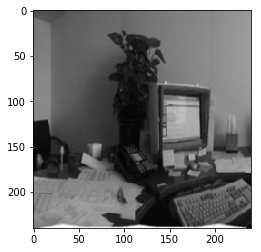

In [0]:
# Verify image
plt.imshow(cv2.resize(train_data[1], img_new_size), cmap='gray')
print(train_data[0].dtype)

In [0]:
n_train = len(train_label)
n_test = len(test_label)

# feature extraction
def extract_feat(raw_data):
    print(len(raw_data))
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    
    for i in np.arange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
#         print(raw_data[i].size)
    print("feat",len(feat))
    
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(16) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(n_test):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(n_test)

print("The accuracy of my dummy model is {:.2f}%".format(accuracy*100))

2400
feat 2400
400
feat 400
The accuracy of my dummy model is 7.00%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [0]:
test_data.shape

(400, 240, 240)

In [0]:
# Write your codes here
interpolation = cv2.INTER_AREA
tiny_img_size = (16, 16)


def resize(x, interpolation):
  
  return np.array([cv2.resize(image, tiny_img_size, interpolation = interpolation) for image in x] ).reshape(len(x), -1)

start = time.time()

tiny_train_x = resize(train_data, interpolation)
tiny_test_x = resize(test_data, interpolation)

end = time.time()
print("Resize time", end-start)


Resize time 0.10879778861999512


In [0]:
n_neighbors = 1
weights = ['distance', 'uniform']

def train_and_test(train_data, train_label, test_data, test_label, interpolation, n_neighbors):
 
  for weight in weights:
    print('weight', weight)
    clf = KNeighborsClassifier(n_neighbors, weights=weight)
    clf.fit(tiny_train_x, train_label)
    pred = clf.predict(tiny_test_x.reshape(len(tiny_test_x), -1))
    print(np.mean(pred == test_label))
  return pred, test_label



In [0]:
start = time.time()

pred1, label1 = train_and_test(tiny_train_x, train_label, tiny_test_x, test_label, interpolation, n_neighbors)

end = time.time()

print("Accuracy", accuracy_score(pred1, label1))
print("Train and test time", end-start)

weight distance
0.2275
weight uniform
0.2275
Accuracy 0.2275
Train and test time 1.0429747104644775


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

After you obtain the Bag of SIFT feature representation of the images, you have to
train a KNN classifier in the Bag of SIFT feature space and report your test set accuracy and time consumption. 

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).
- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

In [0]:
# Write your codes here
gc.collect()
n_clusters = 64
step_size = 25
scale = 10

def get_descriptors(imgs):
  
  descriptors = []
  
  print("getting descriptors")
  for img in imgs:
    
    sift = cv2.xfeatures2d.SIFT_create()
  
    kps = np.array([cv2.KeyPoint(x, y, _size = scale) for x in range(0, img.shape[0], step_size) for y in range(0, img.shape[1], step_size)])
    kps, desc = sift.compute(img, kps)
    descriptors.append(desc)

  return np.array(descriptors)

def get_train_hists(train_data):
  
  train_local_features = get_descriptors(train_data)
  print("getting kmeans", train_local_features.shape)
  if len(train_local_features.shape) == 1:
    kmeans = KMeans(n_clusters=n_clusters, verbose=0).fit(train_local_features)
  else:
    kmeans = KMeans(n_clusters=n_clusters, verbose=0).fit(train_local_features.reshape(-1, 128))
  
  train_hists = []
  
  print("getting train hists", train_local_features.shape)
  for des in train_local_features:
    hist = np.zeros(n_clusters)
    hist[kmeans.predict(des.reshape((-1,128)))] += 1
    train_hists.append(hist)
  
  train_hists = np.array(train_hists)
  
  train_hists = train_hists / 128 # normalisation
  
  return train_hists, kmeans

def get_test_hists(test_data, kmeans):
  
  test_local_features = get_descriptors(test_data)
  test_hists = []
  
  print("getting test hists")
  for des in test_local_features:
    hist = np.zeros(n_clusters)
    hist[kmeans.predict(des.reshape((-1,128)))] += 1
    test_hists.append(hist)
  
  test_hists = np.array(test_hists)
  test_hists = test_hists / 128 # normalisation
  
  return test_hists
  
  
  


In [0]:
start = time.time()

train_hists, kmeans = get_train_hists(train_data)

end = time.time()

print("Time", end-start)

getting descriptors
getting kmeans (2400, 100, 128)
getting train hists (2400, 100, 128)
Time 649.695228099823


In [0]:
start = time.time()

test_hists = get_test_hists(test_data, kmeans)

end = time.time()

print("Time", end-start)

getting descriptors
getting test hists
Time 7.829341173171997


In [0]:
n_neighbors = 50
neigh = KNeighborsClassifier(n_neighbors = n_neighbors, weights='distance')

def train_and_test(train_hists, train_label, test_hists, test_label, seed=0):
      
  print("fitting", train_hists.shape, train_label.shape)
  p = np.random.RandomState(seed = seed).permutation(len(train_label))
  neigh.fit(train_hists[p], train_label[p])
#   neigh.fit(train_hists, train_label) 

  gc.collect()
  
  
  print("predicting", test_hists.shape, test_label.shape)
  pred_neigh_labels = neigh.predict(test_hists)

  gc.collect()
  
  return pred_neigh_labels, test_label

In [0]:

# seed=3010 48
start = time.time()

# train_hists, kmeans = get_train_hists(train_data)
# test_hists = get_test_hists(test_data, kmeans)

pred2, label2 = train_and_test(train_hists, train_label, test_hists, test_label, seed=3010)

end = time.time()

print("Accuracy", accuracy_score(pred2, label2))
print("Time", end-start)

fitting (2400, 64) (2400,)
predicting (400, 64) (400,)
Accuracy 0.47
Time 0.30456089973449707


## Problem 3.a: Bag of SIFT Representation + one-vs-all SVMs
{15 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 16-way classification problem
(the library has handled it for you). To decide which of 16 categories a test
case belongs to, you will train 16 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 16 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: For this question, you need to generate class prediction for the images in **test2** folder using your best model. The prediction file(**Surname_Givenname_SBUID_Pred.txt**) should follow the exact format as given in the **sample.txt** file.10 points will be given to students whose accuracy ranks top 3 in this homework.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [0]:
# Write your codes here
from sklearn import svm
def train_and_test(train_hists, train_label, test_hists, test_label, lambda_val=10, seed=0):
  
  categories = np.unique(train_label)
#   print('categories', categories)
  clf = svm.LinearSVC(tol=1e-5, penalty ='l2', dual=True, C=lambda_val, max_iter = 1000)
#   clf = svm.SVC(C = lambda_val, gamma = 'scale', decision_function_shape='ovr')
  p = np.random.permutation(len(train_label))
  clf.fit(train_hists[p], train_label[p])
  
#   clf.fit(train_hists, train_label)
#   print('train acc', accuracy_score(clf.predict(train_hists), train_label))
  pred_label = clf.predict(test_hists)

  return pred_label, test_label
  


In [0]:
lambda_val = 12
start = time.time()
pred3, label3 = train_and_test(train_hists, train_label, test_hists, test_label, lambda_val, seed=2)


end = time.time()

print("Accuracy", accuracy_score(pred3, label3))
print("TrainTest Time", end-start)

Accuracy 0.5
TrainTest Time 1.0666847229003906


In [0]:
#BONUS

def load_dataset_test(path):
  data, names = [],[]
  print("Loading images from test2")
  img_path = glob.glob(path + '/*.jpg')
  for _,_, files in os.walk(path):
    for filename in sorted(files):
      names.append(filename[:-4])
      data.append(cv2.imread(os.path.join(path,filename), 0))
#   for filename in img_path:
#       data.append(cv2.imread(filename, 0))
  return data, names

# test_data2, names = load_dataset_test('./data/test2/')
# n_test2 = len(test_data2)
# print("n_test: %s" % n_test2)

# file = open('test2.pkl','wb')
# pickle.dump(test_data2, file)
# file.close()

# with open('test2names.txt', 'w') as file:
#     file.writelines("%s\n" % name for name in names)

file = open('test2.pkl', 'rb')
test_data2 = pickle.load(file)
file.close()

names = []

with open('test2names.txt', 'r') as file:
    filecontents = file.readlines()

    for line in filecontents:
        current_place = line[:-1]
        names.append(current_place)

print(len(test_data2))   # Verify number of testing samples

400


In [0]:
train_data2 = np.concatenate([train_data, test_data], axis=0)
train_label2 = np.concatenate([train_label, test_label], axis=0)



train_hists2, kmeans2 = get_train_hists(train_data2)
# train_hists2 = train_hists.copy()
# train_label2 = train_label.copy()
print('train_data2', train_data2.shape, 'train_label2', train_label2.shape)
test_hists2 = get_test_hists(test_data2, kmeans)

getting descriptors
getting kmeans (2800, 100, 128)
getting train hists (2800, 100, 128)
train_data2 (2800, 240, 240) train_label2 (2800,)
getting descriptors
getting test hists


In [0]:
def train_and_predict(train_hists2, train_label2, test_hists2):
      
  print("fitting", train_hists2.shape, train_label2.shape)
  clf = svm.SVC(C = lambda_val,gamma='scale', decision_function_shape='ovr')
  
  p = np.random.permutation(len(train_label))
  clf.fit(train_hists[p], train_label[p])
  gc.collect()
  
  print('train acc', accuracy_score(clf.predict(train_hists), train_label))
  
  print("predicting", test_hists2.shape)
  pred_neigh_labels2 = neigh.predict(test_hists2)
  
  return pred_neigh_labels2


pred_test2 = train_and_predict(train_hists2, train_label2, test_hists2)

filename = 'Shah_Karan_112715555_Pred.txt'

import pandas as pd
d = {'Name':names, 'Class_id':pred_test2}
pred_final = pd.DataFrame(data = d)
pred_final.to_csv(filename, index=None, sep=' ', mode='a')

fitting (2800, 64) (2800,)
train acc 0.9995833333333334
predicting (400, 64)


## Problem 3.b
{5 points} Repeat the evaluation above for different sizes of training sets and draw a plot to show how the size of the training set affects test performace. Do this for training set sizes of 800, 1200, 1600, 2000, 2200, and 2300 images. Randomly sample the images from the original training set and evaluate accuracy. Repeat this process 10 times for each training set size and report the average prediction accuracy. How does performance variability change with training set size? How does performance change? Give reason for your observations.

Size 800
Mean Accuracy 0.45075000000000004 of [0.5, 0.46, 0.44, 0.5025, 0.4175, 0.4325, 0.4325, 0.4525, 0.4425, 0.4275]
**********
Size 1200
Mean Accuracy 0.47174999999999995 of [0.4775, 0.465, 0.455, 0.4625, 0.5025, 0.47, 0.455, 0.4725, 0.475, 0.4825]
**********
Size 1600
Mean Accuracy 0.47850000000000004 of [0.4825, 0.465, 0.4675, 0.5025, 0.4625, 0.445, 0.5175, 0.46, 0.4925, 0.49]
**********
Size 2000
Mean Accuracy 0.4967499999999999 of [0.5075, 0.505, 0.4925, 0.4825, 0.4975, 0.4925, 0.4875, 0.5075, 0.495, 0.5]
**********
Size 2200
Mean Accuracy 0.495 of [0.4925, 0.5075, 0.4875, 0.5125, 0.5, 0.5, 0.4775, 0.485, 0.4825, 0.505]
**********
Size 2300
Mean Accuracy 0.49625 of [0.495, 0.5, 0.4925, 0.51, 0.495, 0.4825, 0.505, 0.4975, 0.4825, 0.5025]
**********


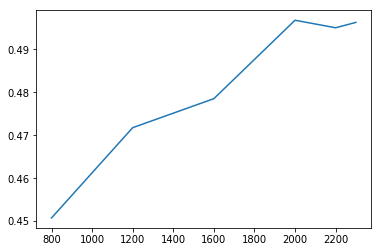

In [0]:
# Write your codes here

sizes = [800, 1200, 1600, 2000, 2200, 2300]
acc_list = []  
mean_acc_list = []
for size in sizes:
  print("Size", size)
  accs = []
  for i in range(10):
#     print(i,'th iteration')
    
    p = np.random.RandomState(seed=i + 42).permutation(len(train_data)) # shuffling images
    train_hists, train_label = train_hists[p], train_label[p]
  
    train_x, train_y = train_hists[:size], train_label[:size]
    pred3, label3 = train_and_test(train_x, train_y, test_hists, test_label)
  
    acc = accuracy_score(pred3, label3)
    accs.append(acc)

  mean_acc = np.mean(np.array(accs))    
  mean_acc_list.append(mean_acc)
  acc_list.append(accs)
  print("Mean Accuracy", mean_acc, "of", accs)
  print("*"*10)

import seaborn as sns
sns.lineplot(x = sizes, y = mean_acc_list)
plt.show()


How does performance variability change with training set size? How does performance change? Give reason for your observations.

Here, I am shuffling training data and selecting a subset to train the classifier to evaluate on test data. Out of data size 2400, subset size starts from 800, which is 1/3 of data. This undoubtebly underperforms than the full data. Graph shows accuracy is almost linear correlated with training data size. That straight line may break at higher end sometimes. From looking at standard deviation at each size, decrease in standard deviation is observed while increased sizes. This is logically true as well because less but random sampled data will have more sensitive accuracy than large sized data while validated on unseen data.

## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 40-50%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 50-70%). <br>



```
Algorithm     Data Processing time  TrainTestTime    Max Accuracy
1st                 0.1127             0.5204         0.2275
2nd                  705               0.2811          0.48 
3rd                  705               1.063          0.5025
```

**1st: Tiny images representation and nearest neighbor classifier**
To resize the images, I have used INTER_AREA interpolation method, which resamples using pixel area relation. In terms of (information loss / appearance), I think this interpolation will be better than other methods, but at the cost of processing time. I have resized each image to (16,16) size and then trained using KNeighborsClassifier (n neighbors =1. For the case of n_neighbors > 1, I used distance function as weight, where closer neighbors will have a greater influence than neighbors far away.This performed well according to expectation with 0.2275 accuracy.

**2nd: Bag of SIFT representation and nearest neighbor - classifier**
To computer descriptors for each image, I am providing densely sampled keypoints(step size = 25, scale = 10). The descripters are then used in KMeans(n clusters=64) to get a normalised histogram out of it.The histograms are given as training data along with true labels to KNeighboursClassifier(n_neighbors = 50, weight = 'distance') after shuffling. The model is able to gain 0.48 accuracy which is significant improvement (+0.26 improvement than in problem 1).

**3rd: Bag of SIFT representation and linear SVM classifier**
SVMs! In image classification, it is usually assumed that SVMs perform better than NN classifiers in some kind of datasets. Therefore, I used the same data from problem 2 to validate this assumption. Using linear SVMs for multiclass classification was handled by sklearn.svm.SVC. The parameter I could tune was lambda value, else in worst case I could use data with different feature sizes more convenient with SVMs. Maximum accuracy with svm.SVC(lambda = 10, kernel = 'linear', decision_function_shape='ovr') was 0.50. I also experimented with rbf kernel with gamma as scale, which performs slightly better than the linearSVM.

<Figure size 864x864 with 0 Axes>

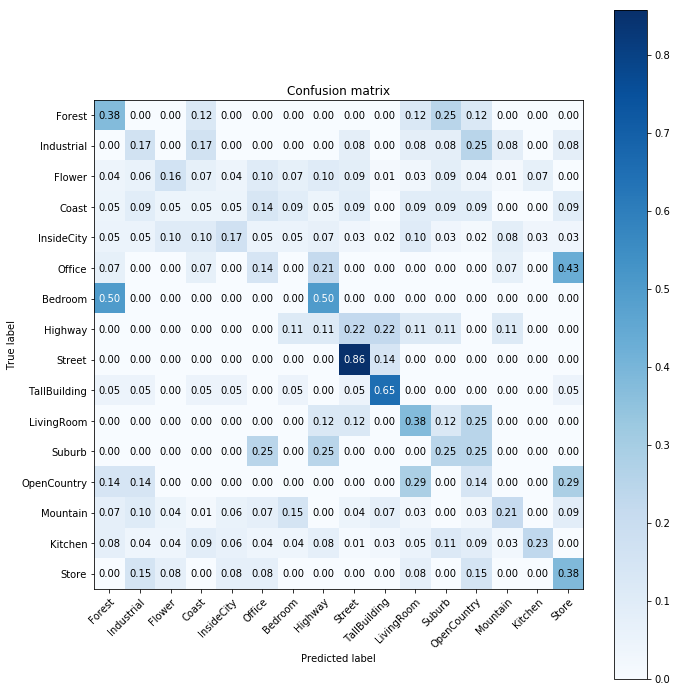

<Figure size 864x864 with 0 Axes>

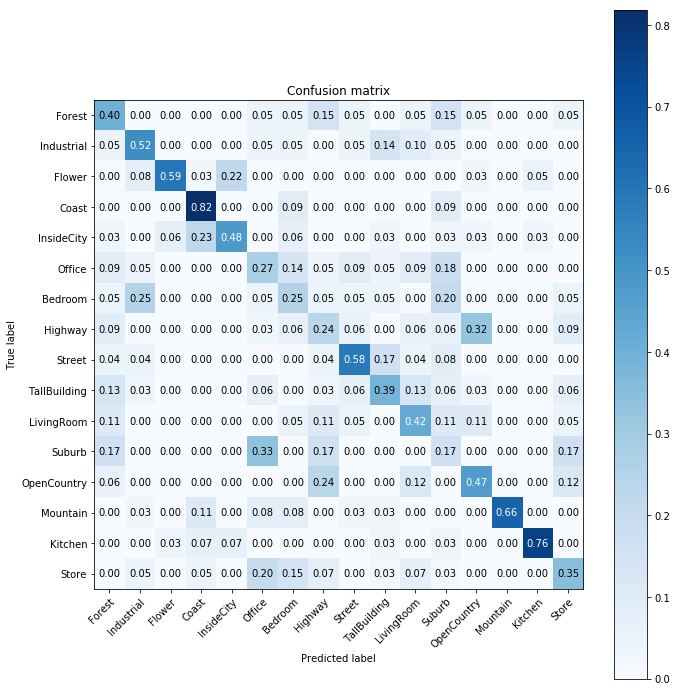

<Figure size 864x864 with 0 Axes>

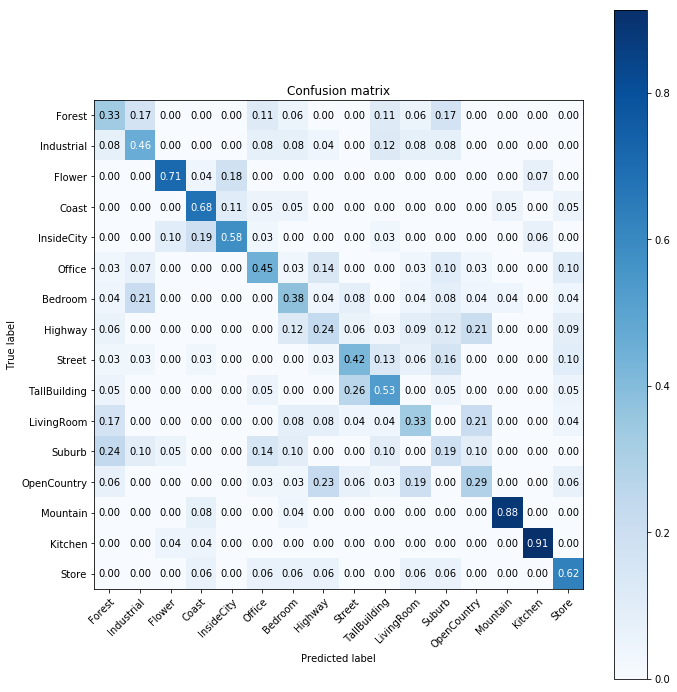

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / np.sum(cm, axis= 1)[..., np.newaxis]
      
    fig, ax = plt.subplots(figsize = (10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

c_names = [name[13:] for name in glob.glob('./data/train/*')]

#First combination:
# Confusion matrix
cm1 = confusion_matrix(pred1, label1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()

#Second combination:
# Confusion matrix
cm2 = confusion_matrix(pred2, label2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(pred3, label3)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()